In [1]:
import torch
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# !pip install -q -r requirements.txt
# !pip install livelossplot==0.5.4

# Exploring CNN - Fine Tuning
## Improving CNN Performances

Exploring:
 - Data Augmentation
 - Hyperparamenter Tuning 
     - Learning Rate Finder
     - Learing Rate Scheduler

 Helper Functions Code Credit - Udacity DL Nanodegree Program

---
### Data Augmentation

Here we write two functions that create appropriate transforms for the training, validation and test dataset, and then create the relative dataloaders.

##### CIFAR10 Data Specs:
- data : a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
- labels : a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.


In [3]:
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import random
import multiprocessing
from helpers import get_train_val_data_loaders, get_test_data_loader
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

def get_transforms(rand_augment_magnitude):
    """
    Defines the transformations including augmentations that must be applied to training, validation and testing datacuts. 
    Function's body is in the Return statement and thus returns a full dictionary 
    with all the transformations and definitions so that all transforms are pulled into main program once and each is accessed more conveniently.
    """
    # CIFAR-10 dataset mean and std per channel obtained from source
    mean = (0.49139968, 0.48215827, 0.44653124)
    std = (0.24703233, 0.24348505, 0.26158768)

    # Define our transformations
    # T.Compose helps to chain series of transformations like nn.Sequential chains layers of a NN.
    return {
        "train": T.Compose(
            [
                # All images in CIFAR-10 are 32x32. We enlarge them a bit so we can then
                # take a random crop
                T.Resize(40),
                
                # take a random part of the image
                T.RandomCrop(32),
                
                # Horizontal flip is not part of RandAugment so doing it manually
                T.RandomHorizontalFlip(0.5),
                
                # RandAugment
                # T.RandAugment has 2 main parameters: how many transformations should be
                # applied to each image, and the strength of these transformations. This
                # latter parameter should be tuned through experiments: the higher the more
                # the regularization effect.
                # Setting up a RandAugment transformation using 2 as num_opts, and the
                # rand_augment_magnitude input parameter as magnitude. 
                # T.InterpolationMode.BILINEAR as interpolation
                
                T.RandAugment(
                    num_ops=2,
                    magnitude=rand_augment_magnitude,
                    interpolation=T.InterpolationMode.BILINEAR,
                ),
                T.ToTensor(), # input are PIL datatype so convert to Tensor
                T.Normalize(mean, std),
            ]
        ),
        "valid": T.Compose(
            [
                # Academic dataset like CIFAR10 are clean but not so in real world 
                # so keeping below two statements despite being useless here.
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:                
                T.ToTensor(),  # input are PIL datatype so convert to Tensor
                T.Normalize(mean, std),
            ]
        ),
        # Identical to the valid set in this case
        "test": T.Compose(
            [
                # Academic dataset like CIFAR10 are clean but not so in real world 
                # so keeping below two statements despite being useless here.
                T.Resize(32),
                T.CenterCrop(32),
                
                # Convert to tensor and apply normalization:                
                T.ToTensor(), # input are PIL datatype so convert to Tensor
                T.Normalize(mean, std),
            ]
        ),
    }

 

def get_data_loaders(batch_size, valid_size, transforms, num_workers, random_seed=42):
    """
    Purpose: Fetches data, splits into train,val, test and loads into Pytorch Dataloaders.
    Returns dictionary with all Dataloaders so this function is called once from main program and then each loader is used as needed in main program
    """
    
    
    # Reseeding random number generators to get a deterministic split. useful
    # when comparing experiments, so one know they all run on the same data.
    # In principle one should repeat this a few times (cross validation) to see
    # the variability of measurements though not doing it here
    torch.manual_seed(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    # Fetch the CIFAR10 training dataset from torchvision.datasets and set the transforms
    # We will later split this further into train and validation
    train_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['train'])
    valid_data = datasets.CIFAR10("data", train=True, download=True, transform=transforms['valid'])

    # Compute how many items we will reserve for the validation set
    n_tot = len(train_data)
    split = int(np.floor(valid_size * n_tot))

    # compute the indices for the training set and for the validation set
    shuffled_indices = torch.randperm(n_tot)
    train_idx, valid_idx = shuffled_indices[split:], shuffled_indices[:split]

    # samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # preparing data loaders (combine dataset and sampler)
    # We will use train_data for the train dataloader and valid_data
    # for the valid_loader, so respective transforms applied
    train_loader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers
    )
    
    test_data = datasets.CIFAR10("data", train=False, download=True, transform=transforms['test'])
    test_loader = torch.utils.data.DataLoader(
        test_data, batch_size=batch_size, num_workers=num_workers
    )
    
    return {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

# defining the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# Model Definition

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self, n_classes=10):

        super(Net, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, 3, padding=1),  # -> 32x16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 32x8x8
            
            nn.Conv2d(32, 64, 3, padding=1),  # -> 64x8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 64x4x4
            
            nn.Conv2d(64, 128, 3, padding=1),  # -> 128x4x4
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # -> 128x2x2
            
            nn.Flatten(),  # -> 1x64x4x4
            
            nn.Linear(128 * 2 * 2, 500),  # -> 500
            nn.Dropout(0.5),
            #  batch normalization (BatchNorm1d NOT BatchNorm2d) 
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, n_classes),
        )

    def forward(self, x):
        return self.model(x)


model = Net()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

---
# Pre-Training Learning Rate Finder

- Custom LR finder will use small amount of data (0.4% of train dataset), run it through the network with random weights (the weights will be erased before real training), use a PyTorch LR Scheduler to change the LR and finalize a decent lr. The goal is to find a stable learning rate range - a rough range
- Empirically, lr_finder helps avoid very bad choices (like an LR that’s too high, causing divergence) if one is not used. Even though it's not perfect, it gets us into a reasonable range faster than manual tuning.


Training:  32%|█████████▊                     | 199/625 [00:18<00:40, 10.53it/s]


(2.326096513567593, 2.478166046802815)

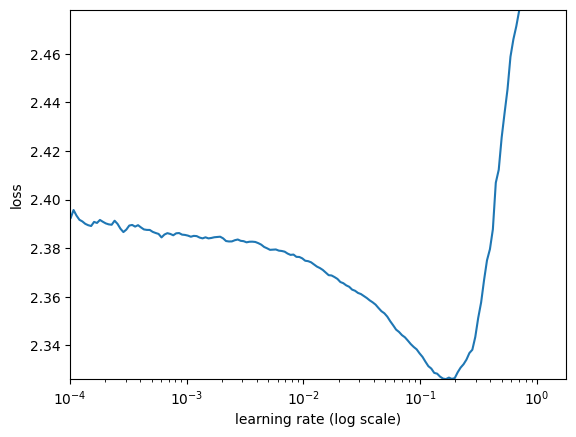

In [5]:
# lr_finder definition is in the lr_finder.py file
from lr_finder import lr_finder
import matplotlib.pyplot as plt

batch_size = 64
valid_size = 0.2
num_workers = multiprocessing.cpu_count()

transforms = get_transforms(rand_augment_magnitude=9)
data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)

# Range  and number of steps for the learning rate
min_lr = 1e-5
max_lr = 1
n_steps = min(len(data_loaders['train']), 200)

# specify loss function (categorical cross-entropy)
loss = nn.CrossEntropyLoss()

# lr_finder takes small samples and runs through the network with randomized weights while finding a good range for LR
losses = lr_finder(min_lr, max_lr, n_steps, loss, model, data_loaders)

# Plot the results
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.xlim([1e-4, None])
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

##### Selection of the Learning Rate
- You do not pick the lr of the lowest loss point since it is just before loss spikes and so an unstable point. Lowest point is on the edge of divergence and using it might cause instability
- You pick an lr at the middle of the sloping line. Left of it is flat (flat indicating slow convergence) while right shows divergence. The middle of the slope is high enough to learn fast but low enough to remain stable.

##### Empirical Best Practices
Many deep learning practitioners have found that picking a LR about 10× smaller than the min-loss LR gives the best convergence. This avoids sudden spikes while still benefiting from fast learning.

---
## Learning Rate Scheduler + Hyperparameter Optimization

Use Learning Rate Scheduler, that changes the learning rate as the training progresses.

We need to include the LR Scheduler in the trainer function. 


In [6]:
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from helpers_3 import train_one_epoch, valid_one_epoch
import torch.optim


def cnn_trainer(data_loaders, model, optimizer, loss, n_epochs, save_path, interactive_tracking=False):
    
    # plotting function
    def after_subplot(ax: plt.Axes, group_name: str, x_label: str):
        """Add title xlabel and legend to single chart"""
        ax.set_title(group_name)
        ax.set_xlabel(x_label)
        ax.legend(loc="center right")
        
    # initialize tracker for minimum validation loss
    # PlotLosses is primarily useful for interactive, dynamic loss visualization during model training. 
    # Alternative approaches like TensorBoard are more widely adopted.
    if interactive_tracking:
        liveloss = PlotLosses(outputs=[MatplotlibPlot(after_subplot=after_subplot)])
    else:
        liveloss = None

    valid_loss_min = None
    logs = {}

    # Define Learning Rate Scheduler: learning rate scheduler reduces the learning rate when the validation loss reaches a plateau.
    # torch.optim.lr_scheduler.ReduceLROnPlateau, with a threshold of 0.01.
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  
        optimizer, "min", verbose=True, threshold=0.01  
    )  

    for epoch in range(1, n_epochs + 1):

        train_loss = train_one_epoch(
            data_loaders["train"], model, optimizer, loss
        )

        valid_loss = valid_one_epoch(data_loaders["valid"], model, loss)

        # If the validation loss decreases by more than 1%, save the model
        if valid_loss_min is None or (
                (valid_loss_min - valid_loss) / valid_loss_min > 0.01
        ):
            # Save the weights to save_path
            torch.save(model.state_dict(), save_path) 
            valid_loss_min = valid_loss

        # Update learning rate, i.e., make a step in the learning rate scheduler
        # Using validation loss, so that the lr scheduler changes lr when the validation loss is not decreasing anymore           
        scheduler.step(valid_loss)  

        # Log the losses and the current learning rate
        if interactive_tracking:
            logs["loss"] = train_loss
            logs["val_loss"] = valid_loss
            logs["lr"] = optimizer.param_groups[0]["lr"]

            liveloss.update(logs)
            liveloss.send()

## MLFLOW - Tracking parameters and experiments

In [7]:
import mlflow 
from helpers_3 import one_epoch_test

def train_one_model(learning_rate, rand_augment_magnitude, n_epochs):
    
    # get functions below pulls all the defined transforms and data_loaders and saved as dictionary in the variable
    # Calling below variable with a key 'train', 'valid', 'test' provides the corresponding config  
    transforms = get_transforms(rand_augment_magnitude=rand_augment_magnitude)
    data_loaders = get_data_loaders(batch_size, valid_size, transforms, num_workers)
        
    model = Net()
    
    if train_on_gpu:
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss = nn.CrossEntropyLoss()
    
    with mlflow.start_run():
        
        cnn_trainer(data_loaders, model, optimizer, loss, n_epochs, "best_val_loss.pt", interactive_tracking=True)
        
        # Restore best validation loss
        model.load_state_dict(torch.load('best_val_loss.pt'))
        
        # Test model on *validation* set
        val_loss, preds, actuals = one_epoch_test(data_loaders['valid'], model, loss)
        
        # mlflow.log_param to log parameters
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("rand_augment_magnitude", rand_augment_magnitude)
        
        # mlflow.log_metric to log validation loss
        mlflow.log_metric("val_loss", val_loss)
        
        val_accuracy = (np.array(preds)==np.array(actuals)).sum() / len(actuals)
        
        # mlflow to log the validation accuracy as a metric
        mlflow.log_metric("val_accuracy", val_accuracy)
        
        # mlflow.log_artifact to asve the file
        mlflow.log_artifact("best_val_loss.pt")

## Random Search
Let's use the random search technique to explore our hyperparameters:

Text(0.5, 1.0, 'Distribution of Parameters Sampled')

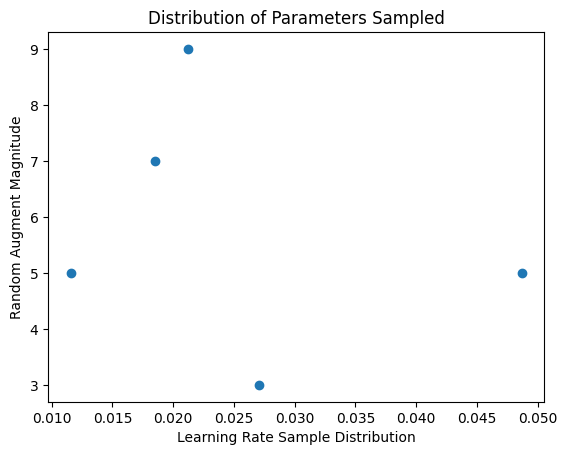

In [13]:
# random grid of learning rate and rand_augment_magnitude
min_lr = 0.01
max_lr = 0.05

# Here you can choose between 5 and 20. The more the better. 
# Typically in real world, one would run even more.
# Benefits from parallelization and so running on cloud with GPU is ideal
n_grid = 5

# we will use log-uniform sampling for learning rate instead of linear sampling
# log-uniform spreads better and diverse when linear clusters near lower/upper bounds
# log-uniform is effective for lr and so highly recommended when sampling
lrs = 10**(np.random.uniform(np.log10(min_lr), np.log10(max_lr), n_grid))

# Normal linear sampling for random augmentation magnitude used during input transformations
r_a_mag = np.random.randint(1, 15, n_grid)

# Plot our grid
_ = plt.scatter(lrs, r_a_mag)
# _ = plt.xscale("log")/
plt.xlabel("Learning Rate Sample Distribution")
plt.ylabel("Random Augment Magnitude")
plt.title("Distribution of Parameters Sampled")

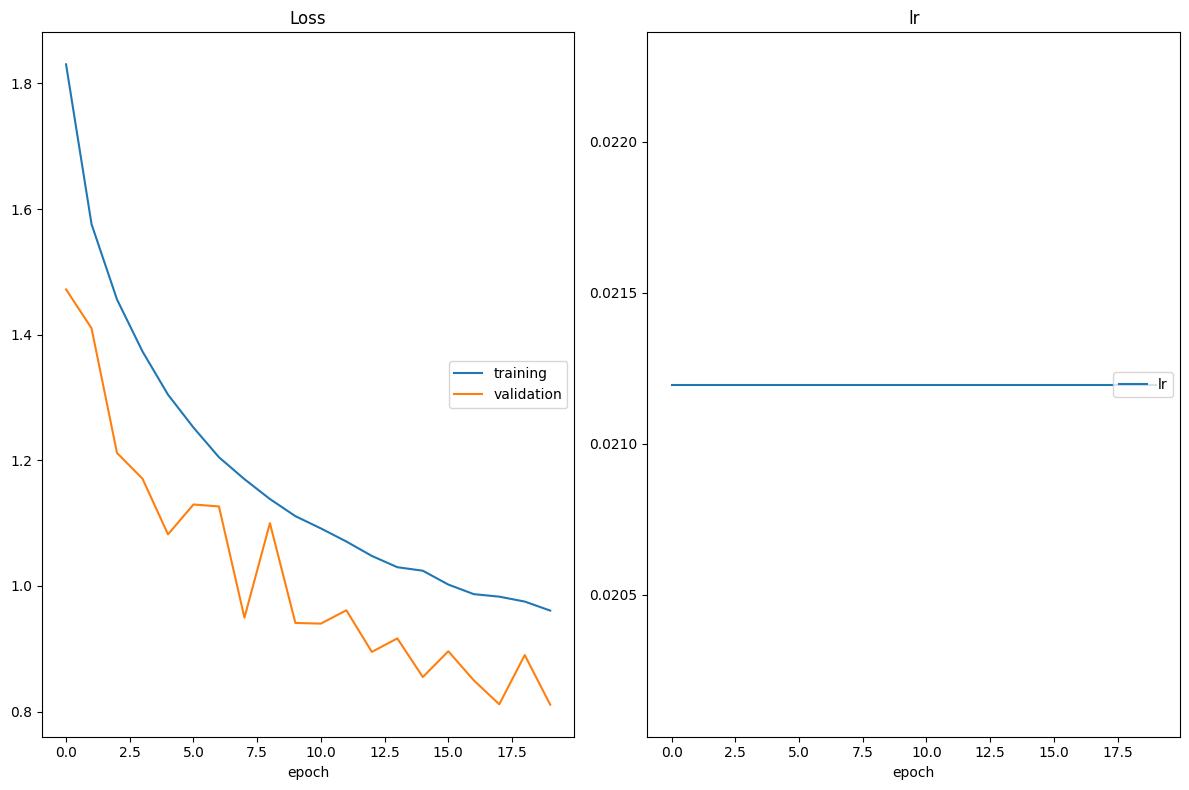

Testing: 100%|████████████████████████████████| 157/157 [00:06<00:00, 23.81it/s]

Test Loss: 0.813955


Test Accuracy: 72% (7222/10000)


In [14]:
# Run our experiments
for lr, rand_aug_mag in zip(lrs, r_a_mag):
    train_one_model(lr, rand_aug_mag, n_epochs=20)

In [15]:
import mlflow

runs = mlflow.search_runs()
sorted_runs = runs[
    [
        "run_id",
        "params.learning_rate",
        "params.rand_augment_magnitude",
        "metrics.val_loss",
        "metrics.val_accuracy",
    ]
].sort_values(by='metrics.val_loss')
sorted_runs

,run_id,params.learning_rate,params.rand_augment_magnitude,metrics.val_loss,metrics.val_accuracy
9,cbe274a71ac6437a8a0bcf79d231d0e4,0.02368863950364078,11,0.652601,0.7822
6,fb81e2f13d0f4bfeb5d9ebc643a207aa,0.02368863950364078,11,0.754076,0.7417
3,d3e1ff5089dc403ea83eb8c28d052ac7,0.027054111253487768,3,0.783415,0.7291
1,a655886608bd44c7bfef642b4d2992a3,0.04866860481863394,5,0.787690,0.7317
2,cb9ddf67e03c4159899fd301457aaa53,0.018506720230108673,7,0.801508,0.7243
0,b7ecf18d80084504bcba9acaef74e6a9,0.0211959683093385,9,0.813955,0.7222
4,190f175797064e67b3b5e5cbbce895ec,0.011569941949244851,5,0.849681,0.7013
5,b6824c73862444e5aabcdda878fcc59d,None,None,NaN,NaN
7,e133b3a03d0c454795472b8f14c454da,None,None,NaN,NaN
8,df6466d5c5f24537b5bc935fea4ac864,None,None,NaN,NaN


In [16]:
from mlflow.tracking import MlflowClient

# Get the id with the lowest val_loss
lowest_loss_id = sorted_runs.iloc[0]['run_id']

# Fetch the best model from that run
client = MlflowClient()
local_path = client.download_artifacts(lowest_loss_id, "best_val_loss.pt", '.')

In [17]:
#  Load the Model with the Lowest Validation Loss
model.load_state_dict(torch.load('best_val_loss.pt'))

<All keys matched successfully>

---
## Test the Trained Network

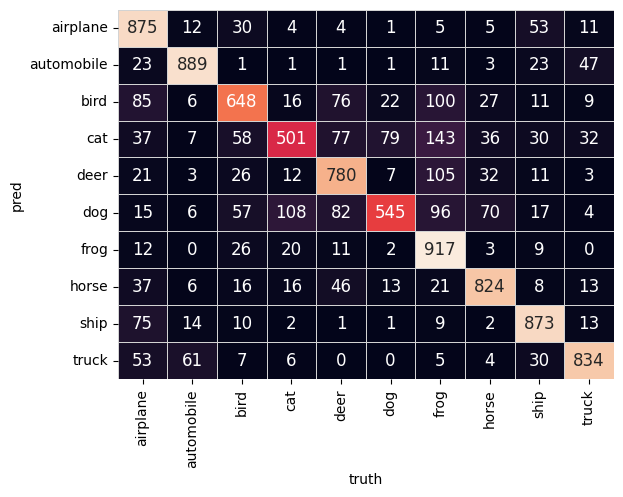

In [19]:
from helpers_3 import plot_confusion_matrix

cm = plot_confusion_matrix(preds, actuals, classes)

In [18]:
from helpers_3 import one_epoch_test

test_loss, preds, actuals = one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 157/157 [00:05<00:00, 26.98it/s]

Test Loss: 0.683479


Test Accuracy: 76% (7686/10000)


### Inference:
CNN accuracy trained in previous notebook had 73% accuracy so we have improved by 3%.